Importieren der notwendigen Bibliotheken

In [25]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

Definieren die CustomDataset Klasse

In [26]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, scores, root_dir, transform=None):
        self.image_paths = image_paths
        self.scores = scores
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name).convert('RGB')
        scores = self.scores[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(scores)

Vorbereitung der Daten

In [27]:
df = pd.read_csv('car_imgs_4000.csv')
image_paths = df['filename'].values
scores = df[['perspective_score_hood', 'perspective_score_backdoor_left']].values

image_paths_train, image_paths_test, scores_train, scores_test = train_test_split(
    image_paths, scores, test_size=0.2, random_state=42)

image_paths_train, image_paths_val, scores_train, scores_val = train_test_split(
    image_paths_train, scores_train, test_size=0.25, random_state=42)

Definieren der Bildtransformationen und Datenloader

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(image_paths=image_paths_train, scores=scores_train, root_dir='imgs', transform=transform)
val_dataset = CustomDataset(image_paths=image_paths_val, scores=scores_val, root_dir='imgs', transform=transform)
test_dataset = CustomDataset(image_paths=image_paths_test, scores=scores_test, root_dir='imgs', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Modell, Verlustfunktion und Optimierer definieren

In [29]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Trainieren des Modells mit Validierungsdaten

In [30]:
num_epochs = 10 
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, scores in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Durchschnittlichen Trainingsverlust für diese Epoche berechnen
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, scores in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, scores)
            val_loss += loss.item()
    
    # Durchschnittlichen Validierungsverlust für diese Epoche berechnen
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

Epoch 1, Train Loss: 0.21445504198471704, Val Loss: 0.06131777033209801
Epoch 2, Train Loss: 0.041071142380436264, Val Loss: 0.0454840724170208
Epoch 3, Train Loss: 0.029685752615332604, Val Loss: 0.0419187206029892
Epoch 4, Train Loss: 0.021688625402748584, Val Loss: 0.030161428675055505


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Trainingsverlust')
plt.plot(val_losses, label='Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.title('Trainings- und Validierungsverlust')
plt.legend()
plt.show()

Evaluierung des Modells auf dem Testset

In [ ]:
model.eval()
total_loss = 0
with torch.no_grad():
    for inputs, scores in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, scores)
        total_loss += loss.item()
average_loss = total_loss / len(test_loader)
print(f'Test Loss: {average_loss:.4f}')

Test Loss: 0.0217


Visualization

Um die Ergebnisse Ihres Modells zu visualisieren, indem Sie die fünf besten und die fünf schlechtesten Vorhersagen aus dem Testdatensatz anzeigen

In [ ]:
# Speichern alle Bilder, vorhergesagten Werte, tatsächlichen Werte und Fehler
all_images = []
all_predicted_scores = []
all_actual_scores = []
all_errors = []

with torch.no_grad():
    for images, scores in test_loader:
        outputs = model(images)
        errors = torch.abs(outputs - scores).mean(1)  # berechnen die Differenz zwischen den vorhergesagten Werten und den tatsächlichen Werten
        # Ergebnisse speichern
        all_images.extend(images)
        all_predicted_scores.extend(outputs)
        all_actual_scores.extend(scores)
        all_errors.extend(errors)

# Sortieren nach Fehlern und erhalten Sie die Indizes der besten und schlechtesten Vorhersagen
sorted_indices = np.argsort(all_errors)
best_indices = sorted_indices[:5]
worst_indices = sorted_indices[-5:]

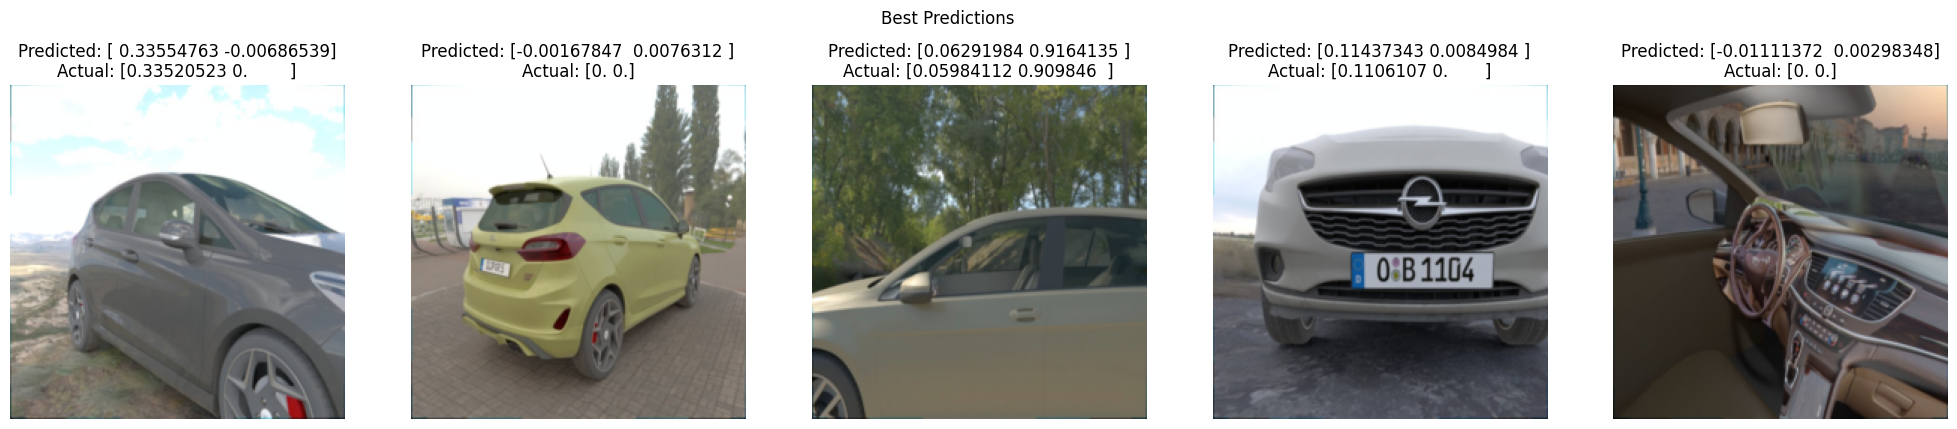

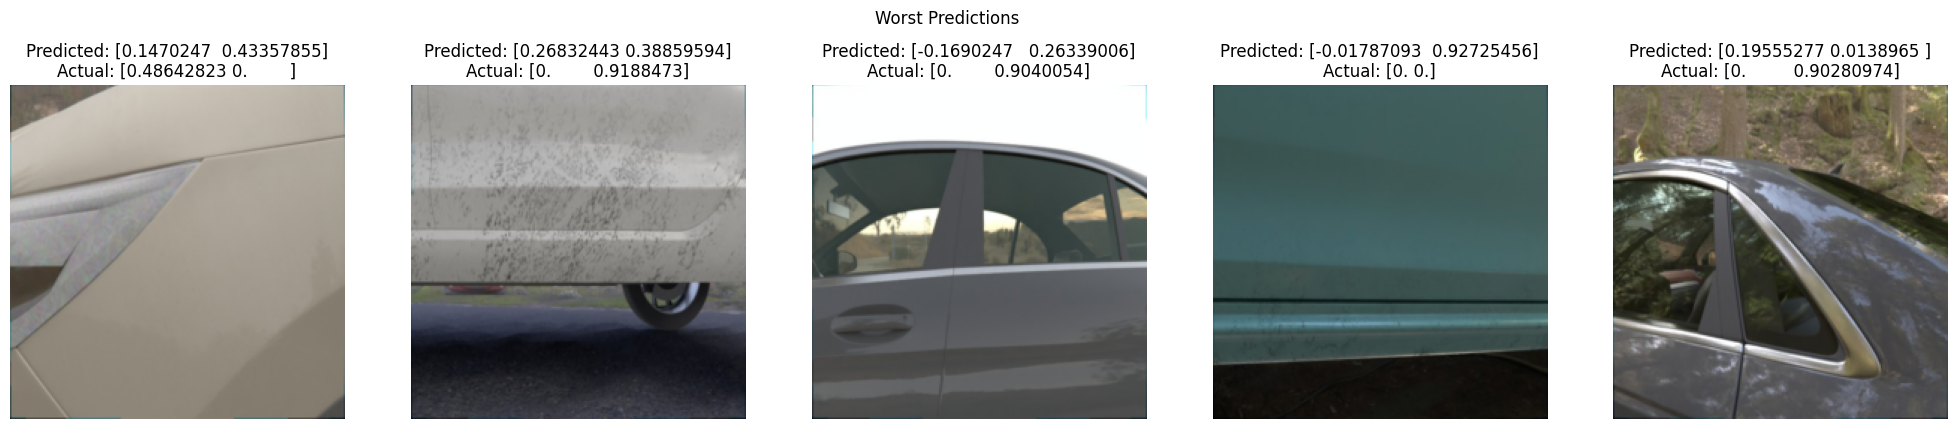

In [ ]:
# Visualisierungsfunktion
def visualize_predictions(indices, title):
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    for i, idx in enumerate(indices):
        img = all_images[idx].numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        predicted_scores = all_predicted_scores[idx].to('cpu').numpy()
        actual_scores = all_actual_scores[idx].to('cpu').numpy()
        axs[i].imshow(img)
        axs[i].set_title(f'Predicted: {predicted_scores}\nActual: {actual_scores}')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Die besten Vorhersagen visualisieren
visualize_predictions(best_indices, 'Best Predictions')


# Die schlechtesten Vorhersagen visualisieren
visualize_predictions(worst_indices, 'Worst Predictions')